In [13]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
bibekbhusal0_generator_pytorch_cganmnist_1_path = kagglehub.model_download('bibekbhusal0/generator/PyTorch/cganmnist/1')
bibekbhusal0_digit_recognizer_pytorch_1_1_path = kagglehub.model_download('bibekbhusal0/digit-recognizer/PyTorch/1/1')

print('Data source import complete.')


Data source import complete.


## Generative Adversarial Networks with Pytorch
Generative adversarial network is a class of deep learning architectures, which are used for unsupervised learning. GAN is my first step to learning generative learning. Here in this notebook I am going to implement Control GAN using Pytorch. I am using [Model](https://www.kaggle.com/models/bibekbhusal0/generator) which I created from [previous version of this notebook](https://www.kaggle.com/code/bibekbhusal0/gan-mnist?scriptVersionId=174119664).

In Generative Adversarial Network the key word is `Adversarial` because two Deep Learning models are competating against each other. One model is **Generator** and other model is **Discriminator**. As the name suggests `Generator` generates images and `Discriminator` classifies images as real or generated.

Generator tries to generate image from something as simple as random noise, Discriminator is trained over fake and real images to classify images. Generated is trained by discriminator's predictions. Generator tries to fool discriminator by creating more realistic images.

This diagram shows how generator and discriminator works together.

![image.png](attachment:8d7aab52-f69a-4900-831b-4c26e3b8fd95.png)


Generator generated images from noise, in control GAN we try to change the noise to get desired output from the model. I am implementint Control GAN in this notebook but it is just small part of the work Control GAN can do. Control GAN has huge application, if you want to learn more about control GAN you can read [this article](https://arxiv.org/abs/2101.02477).

In this we don't need to import any datasets we are just playing with model from previous notebook by generating different images. We don't even need Discriminator. We don't need to use GPU since we are not training it. I am also using [model](https://www.kaggle.com/models/bibekbhusal0/digit-recognizer) from [Digit Recognizer with Pytorch](https://www.kaggle.com/code/bibekbhusal0/digit-recognizer-with-pytorch-accuracy-99-685) just to play around with predictions.

## Importing Libraries

In [14]:
#  Importig libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
import cv2
from PIL import Image

import torch
from torch import nn
from torchvision.utils import make_grid, save_image

In [15]:
def denorm(x):
    out = (x + 1) / 2
    out = out.clamp(0, 1)
    out = out.reshape(out.size(0), 1, 28, 28)
    return out

def show_images(x, nrows = 8):
    plt.imshow(make_grid(denorm(x), nrow = nrows).cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Generator
Generator generates images from random noise of `1024` dimensions.

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 1024
        self.embedding_dim = 128

        def traverseConv(in_chanels, out_chanels, kernel_size = 4, stride = 2, padding = 1, relu = True):
            layers = [
                nn.ConvTranspose2d(in_chanels, out_chanels, kernel_size, stride, padding, bias = False),
                nn.BatchNorm2d(out_chanels)
            ]
            if relu:
                layers.append(nn.LeakyReLU(0.2))
            return layers

        self.main = nn.Sequential(
            *traverseConv(256 * 2 + 1 ,256 ),
            *traverseConv(128 * 2, 128 ),
            nn.Conv2d(128 , 1, 3, 1, 1, bias = False),
            nn.Tanh()
        )

        self.latent = nn.Sequential(
            nn.Linear(self.latent_dim, 7 * 7 * 512 ),
            nn.LeakyReLU(0.2)
        )

        self.embedding = nn.Sequential(
            nn.Embedding(10, self.embedding_dim),
            nn.Linear(self.embedding_dim, 7 * 7 ),
        )
        self.to(device)

    def noise (self, samples = 1):
        return torch.randn(samples, self.latent_dim ).to(device)

    def combine(self, noise, label):
        noise = self.latent(noise)
        label = self.embedding(label.to(device))
        label = label.view(-1, 1,7,7)
        noise = noise.view (-1, 512, 7, 7)
        x = torch.cat((noise, label), 1)

        return x

    def noise_with_label(self, labels):
        return self.combine(self.noise(labels.shape[0]), labels)

    def random_labels(self, samples = 1):
        return torch.randint(0, 10, (samples,)).to(device)

    def generate_random(self, samples):
        return self.generate(self.random_labels(samples))

    def generate_10(self, samples):
        labels = torch.arange(10 * samples, device = device)
        labels = labels % 10
        return self.generate(labels)

    def generate(self, labels):
        return (self(self.noise_with_label(labels)))

    def forward(self, x):
        return self.main(x.to(device))

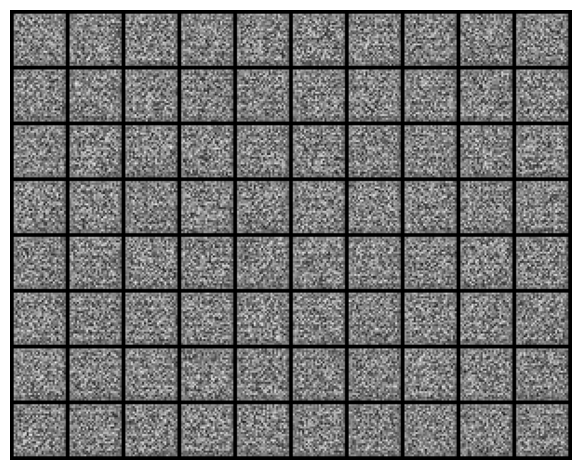

In [18]:
generator = Generator()
show_images(generator.generate_10(8), 10)

## Loading pretrained models

In [19]:
model_path = '/content/generator.pth'
pretrained_model = torch.load(model_path, map_location = device)

generator.load_state_dict(pretrained_model)
generator.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): Tanh()
  )
  (latent): Sequential(
    (0): Linear(in_features=1024, out_features=25088, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (embedding): Sequential(
    (0): Embedding(10, 128)
    (1): Linear(in_features=128, out_features=49, bias=True)
  )
)

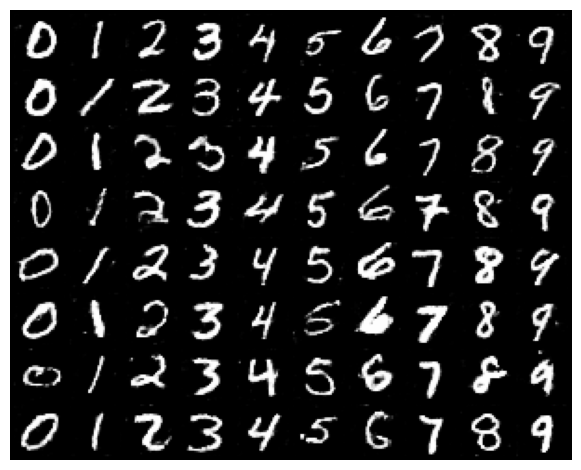

In [20]:
show_images(generator.generate_10(8), 10)

## Digit Recognizer

In [21]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.main =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size  = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size  = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size  = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128 * 3),
            nn.ReLU(),
            nn.Linear(128 * 3 , 10),
            nn.Softmax()
        )
        self.to(device)

    def forward(self, x):
        return self.main(x.to(device))

    def recognize(self, x):
        prediction = self(x + 0.5)
        return prediction.cpu().detach().numpy()


recognizer = DigitRecognizer()

In [22]:
digit_recognizer_path= '/content/digitRecognizer.pth'
pretrained_digit_recognizer = torch.load(digit_recognizer_path, map_location = device)
recognizer.load_state_dict(pretrained_digit_recognizer['model'])
recognizer.eval()

DigitRecognizer(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=384, bias=True)
    (9): ReLU()
    (10): Linear(in_features=384, out_features=10, bias=True)
    (11): Softmax(dim=None)
  )
)

image and preds function is used to plot images and predictions it can alos be saved as image.

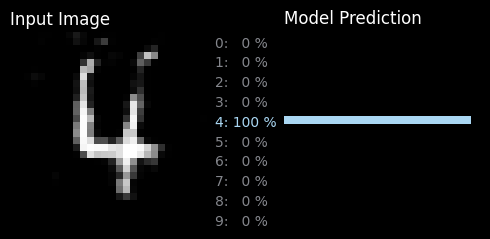

In [23]:
def image_and_pred(noise, show=True, save=False, path=None):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(5, 2.5))
    fig.patch.set_facecolor('black')
    img = generator(noise)
    pred = recognizer.recognize(img)
    img = img.detach().cpu()
    img = img.reshape(28, 28)
    ax1.imshow(img, cmap='gray')
    y = np.arange(10)
    ticks = []

    for i in y:
        ticks.append(f'{i}: {str(round(pred[0][i] * 100)).rjust(3)} %')

    cmap_colors = ['#83868F', '#9EDAFF']  # Light gray to light sky blue
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

    colors = custom_cmap(pred[0])
    barplot = sns.barplot(y=y, x=pred[0], orient='h', ax=ax2, palette=colors)

    ax1.axis('off')
    ax2.set_facecolor('black')
    ax2.tick_params(axis='y', colors='white', which='both', left=False, right=False, bottom=False, top=False)
    ax2.set_xticks([])
    ax2.set_yticklabels(ticks, ha='left')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.set_title('Input Image', color='white', loc='left')
    ax2.set_title('Model Prediction', color='white', loc='left')

    for bar, tick in zip(barplot.patches, ax2.yaxis.get_majorticklabels()):
        tick.set_x(bar.get_x() - 0.3)
        tick.set_color(bar.get_facecolor())
        bar.set_height(0.4)
        bar.set_y(tick.get_position()[1] - 0.2)

    plt.tight_layout()
    if save:
        fig.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

image_and_pred(generator.noise_with_label(torch.randint(0, 10, (1,))), show=True)

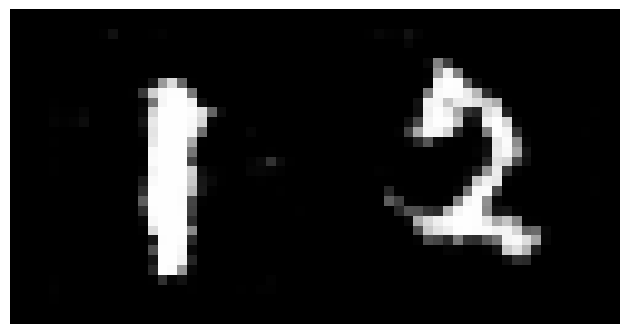

In [25]:
#  Here we generate two images of one and two
one_noise = generator.noise_with_label(torch.tensor([1]))
two_noise = generator.noise_with_label(torch.tensor([2]))

show_images(generator(torch.cat((one_noise, two_noise))), 2)

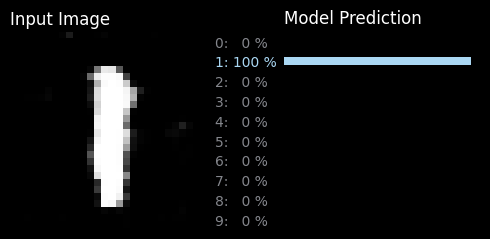

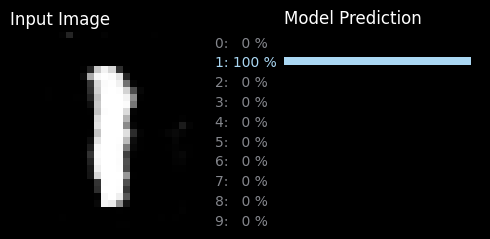

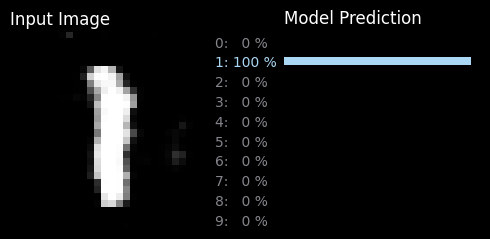

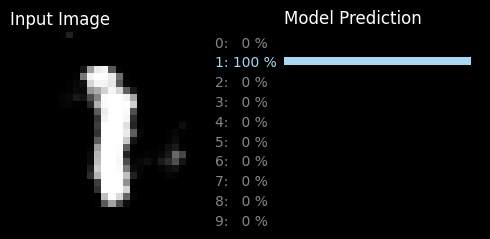

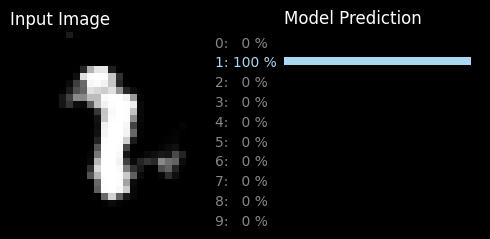

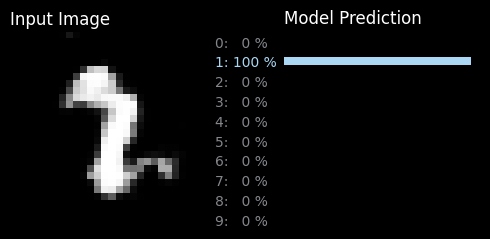

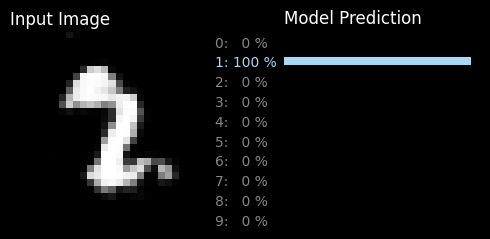

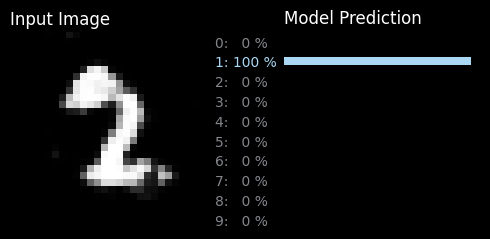

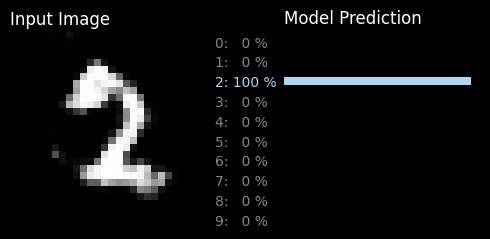

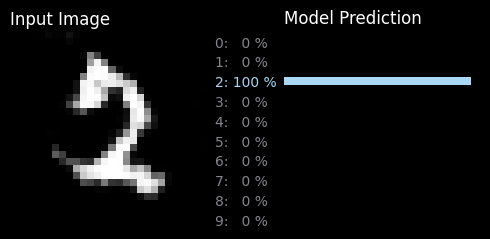

In [26]:
#  let's try to change noise in such a way that one morph to two
#  and see predictions on each image

diff = one_noise - two_noise
frac = diff / 10

for i in range (10):
    noise = one_noise - frac * (i + 1)
    image_and_pred(noise, show = True)

## Generating images
Generated images can be seen in [output](https://www.kaggle.com/code/bibekbhusal0/gan-mnist/output)

In [1]:
folder = '0_to_9'
os.makedirs(folder, exist_ok = True)

for i in range(200):
    num = i % 10
    crr = generator.noise_with_label(torch.tensor([num]))
    if i == 0:
        prev = crr
        continue

    diff = prev - crr
    frac = diff / 10

    for j in range (10):
        file_name = f'{str(i).zfill(4)}_{str(j).zfill(2)}.png'
        path = os.path.join(folder, file_name)
        noise = prev - frac * (j + 1)
        image_and_pred(noise, show = False, save = True, path = path)
    prev = crr

NameError: name 'os' is not defined

In [2]:
image_names = os.listdir(folder)
images = [Image.open(os.path.join(folder, name) ) for name in sorted(image_names)]

NameError: name 'os' is not defined

In [3]:
frame_rate = 10
duration = 1000 // frame_rate
images[0].save(
    '0_to_9.gif',
    save_all = True ,
    append_images = images[1:],
    duration = duration,
    loop = 0
)

NameError: name 'images' is not defined

In [4]:
size = images[0].size
vid_writer = cv2.VideoWriter(
    '0_to_9.mp4',
    cv2.VideoWriter_fourcc(*'mp4v'),
    frame_rate,
    size,
)

for img in images:
    vid_writer.write(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

vid_writer.release()

NameError: name 'images' is not defined

In [31]:
folder = 'random'
os.makedirs(folder, exist_ok = True)

for i in range(200):
    crr = generator.noise_with_label(generator.random_labels(1))
    if i == 0:
        prev = crr
        continue

    diff = prev - crr
    frac = diff / 10

    for j in range (10):
        file_name = f'{str(i).zfill(4)}_{str(j).zfill(2)}.png'
        path = os.path.join(folder, file_name)
        noise = prev - frac * (j + 1)
        image_and_pred(noise, show = False, save = True, path = path)
    prev = crr

In [32]:
image_names = os.listdir(folder)
images = [Image.open(os.path.join(folder, name) ) for name in sorted(image_names)]

In [33]:
frame_rate = 10
duration = 1000 // frame_rate
images[0].save(
    'random.gif',
    save_all = True ,
    append_images = images[1:],
    duration = duration,
    loop = 0
)

In [5]:
size = images[0].size
vid_writer = cv2.VideoWriter(
    'random.mp4',
    cv2.VideoWriter_fourcc(*'mp4v'),
    frame_rate,
    size,
)

for img in images:
    vid_writer.write(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

vid_writer.release()

NameError: name 'images' is not defined

In [6]:
# Save the Generator model
torch.save(generator.state_dict(), 'generator_model.pth')

# Save the DigitRecognizer model
torch.save(recognizer.state_dict(), 'digit_recognizer_model.pth')

NameError: name 'torch' is not defined

In [7]:
# Create instances of the models
generator = Generator()
recognizer = DigitRecognizer()

# Load the state dictionaries
generator.load_state_dict(torch.load('generator_model.pth', map_location=device))
recognizer.load_state_dict(torch.load('digit_recognizer_model.pth', map_location=device))

# Set the models to evaluation mode
generator.eval()
recognizer.eval()

NameError: name 'Generator' is not defined

In [ ]:
# Saving the models
torch.save(generator.state_dict(), 'generator_model.pth')
torch.save(recognizer.state_dict(), 'digit_recognizer_model.pth')

# Loading the models
# Create instances of the models
generator = Generator()
recognizer = DigitRecognizer()

# Load the state dictionaries
generator.load_state_dict(torch.load('generator_model.pth', map_location=device))
recognizer.load_state_dict(torch.load('digit_recognizer_model.pth', map_location=device))

# Set the models to evaluation mode
generator.eval()
recognizer.eval()

DigitRecognizer(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=384, bias=True)
    (9): ReLU()
    (10): Linear(in_features=384, out_features=10, bias=True)
    (11): Softmax(dim=None)
  )
)

In [ ]:
import os
print(os.listdir("/kaggle/working/"))


['0_to_9', '0_to_9.mp4', 'generator_model.pth', '.virtual_documents', 'random.gif', 'digit_recognizer_model.pth', '0_to_9.gif', 'random.mp4', 'random']


If you Learn something new from this notebook, please consider upvoteing it. And also leave a commnet. I will appreciate it. I am also learning new things so there might be some mistakes in this notebook fortunately those mistakes don't show stop execution of the code. But still I will be trying to improve it.

You can also  check out my previous projcets on same MNIST dataset about Digit Recognizer (Also part of getting started challange in Kaggle). Here are the linkes of my previous projects:
- [Digit recognizer with PyTroch](https://www.kaggle.com/code/bibekbhusal0/digit-recognizer-with-pytorch-accuracy-99-685)
- [Digit recognizer with Keras](https://www.kaggle.com/code/bibekbhusal0/digit-recognizer-with-keras-99-978-accurate?scriptVersionId=170678423)
- [Basic GAN](https://www.kaggle.com/code/bibekbhusal0/gan-mnist?scriptVersionId=173909771)
- [Deep Convolutional GAN](https://www.kaggle.com/code/bibekbhusal0/gan-mnist?scriptVersionId=173987543)
- [Condictional GAN](https://www.kaggle.com/code/bibekbhusal0/gan-mnist?scriptVersionId=174119664)
